In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input

# Đọc và tiền xử lý dữ liệu

In [2]:
# Load the dataset
data = pd.read_csv('gld_price_data.csv')
print(data.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
df = data[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date        GLD
0 2008-01-02  84.860001
1 2008-01-03  85.570000
2 2008-01-04  85.129997
3 2008-01-07  84.769997
4 2008-01-08  86.779999


In [4]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df = fill_missing_values_date(df, 'Date', 'GLD')
df.head(10)

,Date,GLD
0,2008-01-02,84.860001
1,2008-01-03,85.570000
2,2008-01-04,85.129997
3,2008-01-05,85.009997
4,2008-01-06,84.889997
5,2008-01-07,84.769997
6,2008-01-08,86.779999
7,2008-01-09,86.550003
8,2008-01-10,88.250000
9,2008-01-11,88.580002


## Nên vẽ đồ thị trước và sau khi xử lý để ta có thể thấy được sự khác biệt

In [5]:
df.set_index('Date', inplace=True)

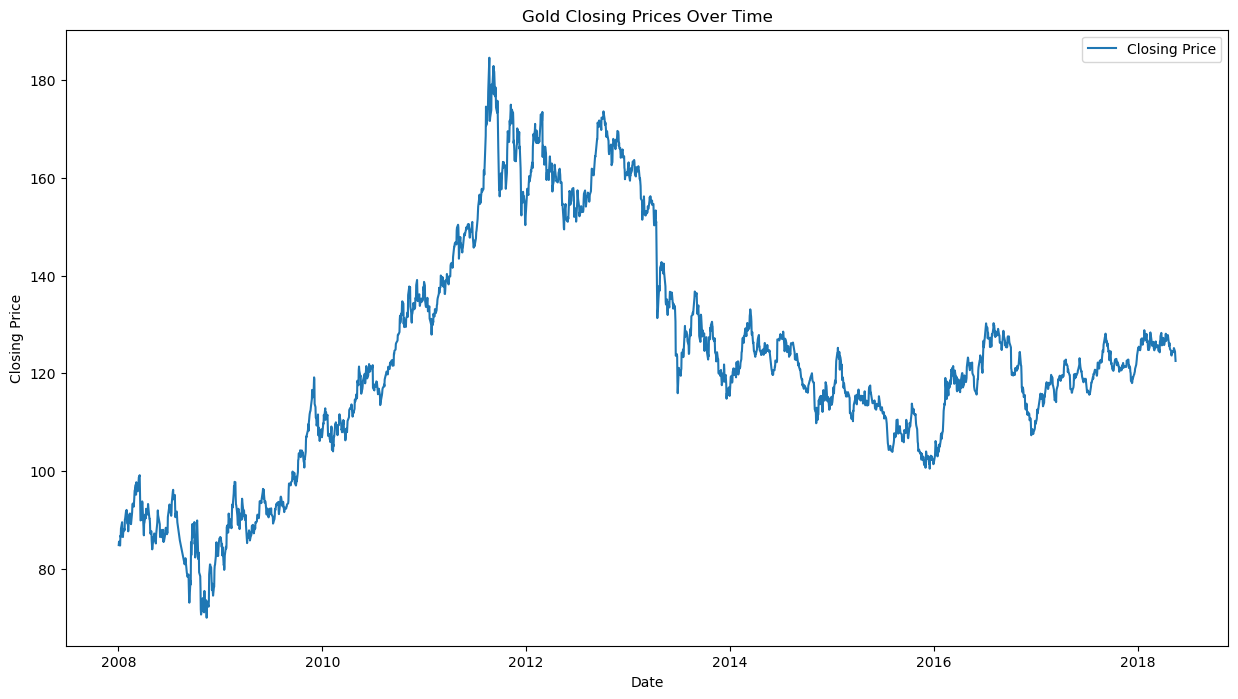

In [6]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.legend()
plt.show()

In [7]:
data = df.values.flatten()

In [8]:
#data = data[:100]

In [9]:
len(data)

3788

# Chuẩn hóa dữ liệu

In [10]:
scaler = MinMaxScaler()  

data_scaled = scaler.fit_transform(data.reshape(-1, 1))
data = data_scaled.flatten()

# Hàm tính đánh giá
## Có thể rút gọn đoạn code sau do không cần khai báo một lớp và gộp 2 hàm thành 1 hàm

In [11]:
class Metrics:  
    def __init__(self, mse, rmse, mae, r2):  
        self.mse = mse  
        self.rmse = rmse  
        self.mae = mae 
        self.r2 = r2 

        
def calculate_metrics(test, predictions):  
    mse = mean_squared_error(test, predictions)  
    rmse = np.sqrt(mse)  
    mae = mean_absolute_error(test, predictions)  
    r2 = r2_score(test, predictions)  
    
    # Tạo đối tượng metrics  
    metrics = Metrics(mse=mse, rmse=rmse, mae=mae, r2=r2)  
    return metrics

def print_metrics(model_name, metrics):  
    print(f'Model: {model_name}')  
    print(f'MSE: {metrics.mse:.4f}')  
    print(f'RMSE: {metrics.rmse:.4f}')  
    print(f'MAE: {metrics.mae:.4f}')  
    print(f'R²: {metrics.r2:.4f}') 

# Chia dữ liệu

In [13]:
train_size = int(len(data) * 0.8)  
train, test = data[:train_size], data[train_size:]

# ARIMA

In [12]:
def run_arima(train, test):  
    # Tìm tham số tốt nhất bằng pm.auto_arima  
    arima_model = pm.auto_arima(train, 
                          start_p=1, start_q=1,
                          max_p=7, max_q=7,
                          start_d=0, max_d=5,
                          seasonal=False,
                          trace=True,
                          stepwise=True) 
    
    # Lấy giá trị p, d, q  
    p, d, q = arima_model.order  
    print(f'Optimal order: p={p}, d={d}, q={q}')

    # Huấn luyện mô hình trên dữ liệu huấn luyện  
    model = ARIMA(train, order=(p, d, q))
    fitted_model = model.fit()  
    
    # Dự đoán giá trị cho train[10:]
    start_index = 10  # Chỉ số bắt đầu bỏ 10 giá trị đầu cho train  
    end_index = len(train) - 1  # Chỉ số cuối cùng trong tập huấn luyện
    train_predictions = fitted_model.predict(start=start_index, end=end_index) 
    
    # Dự đoán giá trị cho test 
    history = [x for x in train]
    test_predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        test_predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    
    test_predictions = np.array(test_predictions)
    
    # Đánh giá
    train_metrics = calculate_metrics(train[start_index:], train_predictions)
    test_metrics = calculate_metrics(test, test_predictions)
    
    return arima_model, train[start_index:], test, train_predictions, test_predictions, train_metrics, test_metrics  

In [14]:
model_arima, train_arima, test_arima, train_pre_arima, test_pre_arima, train_metrics_arima, test_metrics_arima = run_arima(train, test)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-19656.648, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19633.145, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19653.770, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19651.573, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19634.842, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19657.266, Time=2.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19659.262, Time=1.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19657.313, Time=1.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-19655.331, Time=2.71 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19661.029, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19655.514, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-19659.082, Time=1.65 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-19659.032, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-19658.410, Time=2.28 sec
 ARIM

In [15]:
print_metrics("ARIMA", test_metrics_arima)

Model: ARIMA
MSE: 0.0000
RMSE: 0.0055
MAE: 0.0037
R²: 0.9827


# Tính phần dư

In [16]:
train_ffnn = train_arima - train_pre_arima
test_ffnn = test_arima - test_pre_arima

# FFNN

In [17]:
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

time_step = 7

test_temp = np.concatenate((train_ffnn[-time_step:], test_ffnn))

X_train, y_train = create_dataset(train_ffnn, time_step)
X_test , y_test  = create_dataset(test_temp, time_step)

In [50]:
def create_model_ffnn(hidden_layers=1, neurons=50, activation='relu', input_shape=(5,), learning_rate=0.001):
    model = Sequential()
    # Thêm Input layer
    model.add(Input(shape=input_shape))
    model.add(Dense(neurons, activation=activation))
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1))  # Lớp đầu ra
    optimizer = Adam(learning_rate=learning_rate)  
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [59]:
def run_ffnn(X_train, y_train, X_test, y_test):  
    # Tạo mô hình  
    model = KerasRegressor(model=create_model_ffnn, input_shape=(X_train.shape[1],))  
    
    param_grid = {
        'model__hidden_layers': [1, 2, 3],
        'model__neurons': [50, 70, 100, 120],
        'model__activation': ['relu', 'sigmoid', 'tanh'],
        'batch_size': [3, 5, 7, 10, 16, 32],      # Batch size for KerasRegressor
        'epochs': [100, 200],
        'model__learning_rate': [0.001, 0.01, 0.05]
    }
    
    # Perform GridSearchCV for each time_step
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs = -1)
    grid_result = grid.fit(X_train, y_train)
    
    # Bước 6: In các thông số tốt nhất  
    print("Tham số tốt nhất:", grid_result.best_params_)  
    print("Điểm số tốt nhất:", grid_result.best_score_) 

    best_model = grid_result.best_estimator_  
    predictions = best_model.predict(X_test)  

    # Đánh giá mô hình  
    metrics = calculate_metrics(y_test, predictions)  
    
    predictions = predictions.flatten()

    return best_model, metrics, predictions

In [ ]:
model_ffnn, metrics_ffnn, test_pre_ffnn = run_ffnn(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


D:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Tính dự đoán lai ghép

In [ ]:
predictions = test_pre_arima + test_pre_ffnn

# Đánh giá

In [ ]:
print_metrics("ARIMA", test_metrics_arima)
print("\n")
print_metrics("FFNN", metrics_ffnn)
print("\n")

metrics1 = calculate_metrics(test, predictions) 
print_metrics("Lai ghép ARIMA_FFNN (chưa chuẩn hóa ngược lại):", metrics1)
print("\n")

predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
predictions_inverse = predictions_inverse.flatten()

test_inverse = scaler.inverse_transform(test.reshape(-1, 1))
test_inverse = test_inverse.flatten()

metrics2 = calculate_metrics(test_inverse, predictions_inverse) 

print_metrics("Lai ghép ARIMA_FFNN (đã chuẩn hóa ngược lại)", metrics2)